# Import Required Libraries
Import pandas and any other necessary libraries for data analysis.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Load the Dataset
Use pandas to load the QVI_data.csv file into a DataFrame.

In [4]:
# Load the dataset
data = pd.read_csv("QVI_data.csv")

# Set themes for plots
sns.set_theme(style="whitegrid")

# Calculate Metrics

In [5]:
# Convert the DATE column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')

# Create a month ID column
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Define the measure calculations
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn=('PROD_QTY', 'sum'),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

# Filter to the pre-trial period and stores with full observation periods
stores_with_full_obs = measure_over_time.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()
pre_trial_measures = measure_over_time[(measure_over_time['YEARMONTH'] < 201902) &
                                       (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))]

# Calculate Correlation Between Stores

This function calculates the correlation between a trial store and all potential control stores for a given metric. It returns a DataFrame with the correlation values for each store pair.

In [6]:
def calculate_correlation(input_table, metric_col, store_comparison):
    store_numbers = input_table['STORE_NBR'].unique()
    calc_corr_table = []

    for store in store_numbers:
        trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison][metric_col]
        control_store_data = input_table[input_table['STORE_NBR'] == store][metric_col]
        correlation = np.corrcoef(trial_store_data, control_store_data)[0, 1]
        calc_corr_table.append({'Store1': store_comparison, 'Store2': store, 'corr_measure': correlation})

    return pd.DataFrame(calc_corr_table)

# Calculate Magnitude Distance Between Stores

This function calculates a standardized magnitude distance between a trial store and all potential control stores for a given metric. It returns a DataFrame with the average magnitude distance for each store pair.

In [7]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    store_numbers = input_table['STORE_NBR'].unique()
    calc_dist_table = []

    for store in store_numbers:
        trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison][['YEARMONTH', metric_col]]
        control_store_data = input_table[input_table['STORE_NBR'] == store][['YEARMONTH', metric_col]]
        merged = pd.merge(trial_store_data, control_store_data, on='YEARMONTH', suffixes=('_trial', '_control'))
        merged['measure'] = abs(merged[f'{metric_col}_trial'] - merged[f'{metric_col}_control'])
        merged['Store1'] = store_comparison
        merged['Store2'] = store
        calc_dist_table.append(merged[['Store1', 'Store2', 'YEARMONTH', 'measure']])

    calc_dist_table = pd.concat(calc_dist_table)
    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    calc_dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
    calc_dist_table['magnitudeMeasure'] = 1 - (calc_dist_table['measure'] - calc_dist_table['min']) / (calc_dist_table['max'] - calc_dist_table['min'])
    final_dist_table = calc_dist_table.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index(name='mag_measure')

    return final_dist_table

# Calculate Correlation and Magnitude Scores for Trial Store 77

This code performs the following steps:
1. Calculates the correlation scores for total sales (`totSales`) and number of customers (`nCustomers`) between the trial store (store 77) and all potential control stores.
2. Calculates the magnitude distance scores for total sales (`totSales`) and number of customers (`nCustomers`) between the trial store (store 77) and all potential control stores.

In [8]:
trial_store = 77

# Correlation scores
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

# Magnitude scores
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

# Combine Correlation and Magnitude Scores to Select Control Store

This code performs the following steps:
1. **Set Correlation Weight**:
   - A weight (`corr_weight`) of 0.5 is assigned to balance the importance of correlation and magnitude scores.

2. **Calculate Total Sales Score**:
   - Combines the correlation and magnitude scores for total sales (`totSales`) using the formula:
     ```
     scoreNSales = corr_weight * corr_measure + (1 - corr_weight) * mag_measure
     ```

3. **Calculate Customer Score**:
   - Combines the correlation and magnitude scores for number of customers (`nCustomers`) using the formula:
     ```
     scoreNCust = corr_weight * corr_measure + (1 - corr_weight) * mag_measure
     ```

4. **Combine Scores Across Drivers**:
   - Merges the total sales and customer scores into a single DataFrame.
   - Calculates the final control score as the average of the two scores:
     ```
     finalControlScore = 0.5 * scoreNSales + 0.5 * scoreNCust
     ```

5. **Select the Control Store**:
   - Identifies the control store with the highest `finalControlScore` for the given trial store, excluding the trial store itself.
   - Prints the selected control store for the trial store.

In [9]:
# Combine correlation and magnitude scores
corr_weight = 0.5

# Total sales score
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = corr_weight * score_nSales['corr_measure'] + (1 - corr_weight) * score_nSales['mag_measure']

# Customer score
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['corr_measure'] + (1 - corr_weight) * score_nCustomers['mag_measure']

# Combine scores across drivers
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control['finalControlScore'] = 0.5 * score_control['scoreNSales'] + 0.5 * score_control['scoreNCust']

# Select the control store
control_store = score_control[score_control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False).iloc[1]['Store2']
print(f"Control store for trial store {trial_store}: {control_store}")

Control store for trial store 77: 233.0


# Visual Check for Total Sales Trends

This code performs the following steps:
1. **Assign Store Type**:
   - Adds a `Store_type` column to classify stores as "Trial", "Control", or "Other stores" based on the `STORE_NBR`.

2. **Group and Aggregate Data**:
   - Groups the data by `YEARMONTH` and `Store_type`.
   - Calculates the average total sales (`totSales`) for each group.

3. **Create TransactionMonth Column**:
   - Converts the `YEARMONTH` column into a proper datetime format (`TransactionMonth`) for plotting.

4. **Plot Total Sales Trends**:
   - Uses `seaborn.lineplot` to visualize the trends in total sales over time for the trial store, control store, and other stores.
   - Adds labels for the x-axis (Month of Operation), y-axis (Total Sales), and a legend for store types.

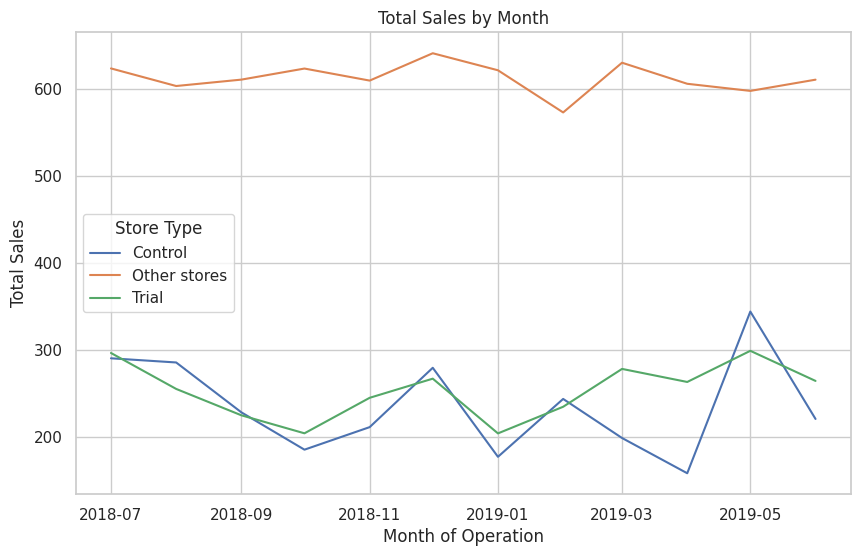

In [10]:
# Visual check for total sales
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    totSales=('totSales', 'mean')
).reset_index()

past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(title='Store Type')
plt.show()

# Evaluation of Sales Uplift During the Trial Period
To evaluate whether there has been an increase in overall chip sales during this time, we'll begin by scaling the control store’s sales to align with the trial store's sales level. This adjustment helps account for any differences between the two stores that existed before the trial period.

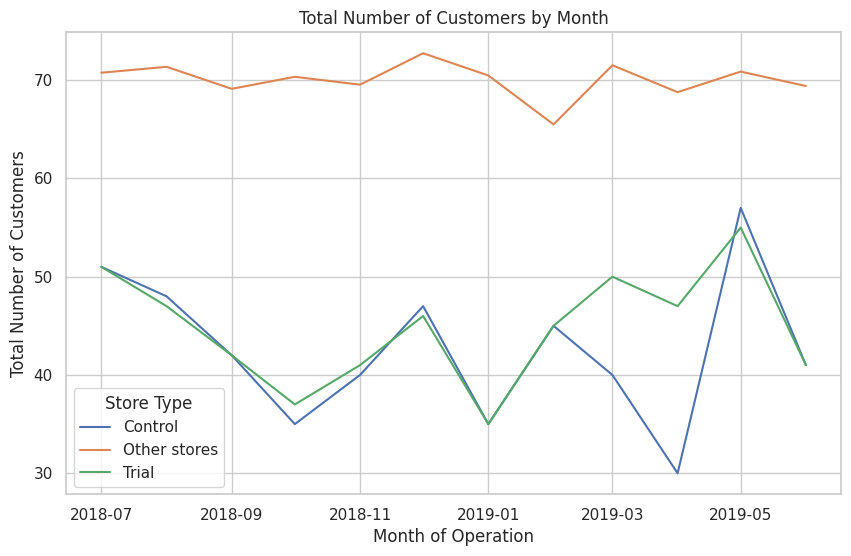

In [11]:
# Visual check for total number of customers
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Group by YEARMONTH and Store_type to calculate the average number of customers
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    numberCustomers=('nCustomers', 'mean')
).reset_index()

# Create TransactionMonth column for plotting
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total number of customers trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='numberCustomers', hue='Store_type')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.legend(title='Store Type')
plt.show()

# Calculate and Apply Scaling Factor for Control Store Sales

This code performs the following steps:
1. **Calculate Scaling Factor**:
   - Computes a scaling factor to align the control store's total sales with the trial store's total sales during the pre-trial period (before February 2019).

2. **Apply Scaling Factor**:
   - Adjusts the control store's total sales (`controlSales`) by multiplying it with the scaling factor to make it comparable to the trial store's sales.

In [12]:
# Calculate scaling factor for control store sales
scaling_factor_sales = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()
)

# Apply the scaling factor to control store sales
measure_over_time['controlSales'] = measure_over_time.apply(
    lambda row: row['totSales'] * scaling_factor_sales if row['STORE_NBR'] == control_store else row['totSales'],
    axis=1
)

# Calculate Percentage Difference Between Trial and Control Sales

This code performs the following steps:
1. **Filter Data for Trial and Control Stores**:
   - Extracts total sales (`totSales`) for the trial store and scaled control sales (`controlSales`) for the control store.

2. **Merge Trial and Control Sales**:
   - Combines the trial and control sales data on `YEARMONTH`.

3. **Calculate Percentage Difference**:
   - Computes the percentage difference between the trial store's sales and the scaled control store's sales.

In [13]:
# Filter data for trial and control stores
trial_sales = measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']]
control_sales = measure_over_time[measure_over_time['STORE_NBR'] == control_store][['YEARMONTH', 'controlSales']]

# Merge trial and control sales
percentage_diff_sales = pd.merge(control_sales, trial_sales, on='YEARMONTH')
percentage_diff_sales['percentageDiff'] = abs(percentage_diff_sales['controlSales'] - percentage_diff_sales['totSales']) / percentage_diff_sales['controlSales']

# Calculate Standard Deviation and T-Values for Percentage Difference

This code performs the following steps:
1. **Calculate Standard Deviation**:
   - Computes the standard deviation of the percentage difference in the pre-trial period (before February 2019).

2. **Set Degrees of Freedom**:
   - Defines the degrees of freedom as 7 (8 months in the pre-trial period minus 1).

3. **Calculate T-Values**:
   - Computes t-values for the percentage difference during the trial period by dividing the percentage difference by the standard deviation.

4. **Create TransactionMonth Column**:
   - Converts the `YEARMONTH` column into a proper datetime format (`TransactionMonth`) for plotting.

5. **Find the 95th Percentile of the T-Distribution**:
   - Uses the `scipy.stats.t` module to calculate the critical t-value at the 95th percentile for the given degrees of freedom.

In [14]:
# Calculate standard deviation of percentage difference in the pre-trial period
std_dev_sales = percentage_diff_sales[percentage_diff_sales['YEARMONTH'] < 201902]['percentageDiff'].std()

# Degrees of freedom
degrees_of_freedom = 7  # 8 months in pre-trial period, so 8 - 1 = 7

# Calculate t-values for the trial period
percentage_diff_sales['tValue'] = percentage_diff_sales['percentageDiff'] / std_dev_sales
percentage_diff_sales['TransactionMonth'] = pd.to_datetime(percentage_diff_sales['YEARMONTH'].astype(str), format='%Y%m')

# Find the 95th percentile of the t-distribution
from scipy.stats import t
t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile of t-distribution: {t_critical}")

95th percentile of t-distribution: 1.894578605061305


# Visualize Total Sales Trends with Confidence Intervals

This code performs the following steps:
1. **Prepare Data for Visualization**:
   - Filters the data for the trial store and control store.
   - Assigns a `Store_type` column to classify stores as "Trial", "Control", or "Other stores".

2. **Calculate Confidence Intervals**:
   - Computes the 95th and 5th percentiles for the control store's total sales using the standard deviation (`std_dev_sales`).

3. **Combine Data for Plotting**:
   - Concatenates the trial store, control store, and confidence interval data into a single DataFrame.

4. **Create TransactionMonth Column**:
   - Converts the `YEARMONTH` column into a proper datetime format for plotting.

5. **Plot Total Sales Trends**:
   - Uses `seaborn.lineplot` to visualize the trends in total sales for the trial store, control store, and confidence intervals.
   - Highlights the trial period (March 2019 to June 2019) with a shaded region.
   - Adds labels for the x-axis (Month of Operation), y-axis (Total Sales), and a legend for store types.

<ipython-input-15-42ae3ca038e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_sales['Store_type'] = past_sales['STORE_NBR'].apply(


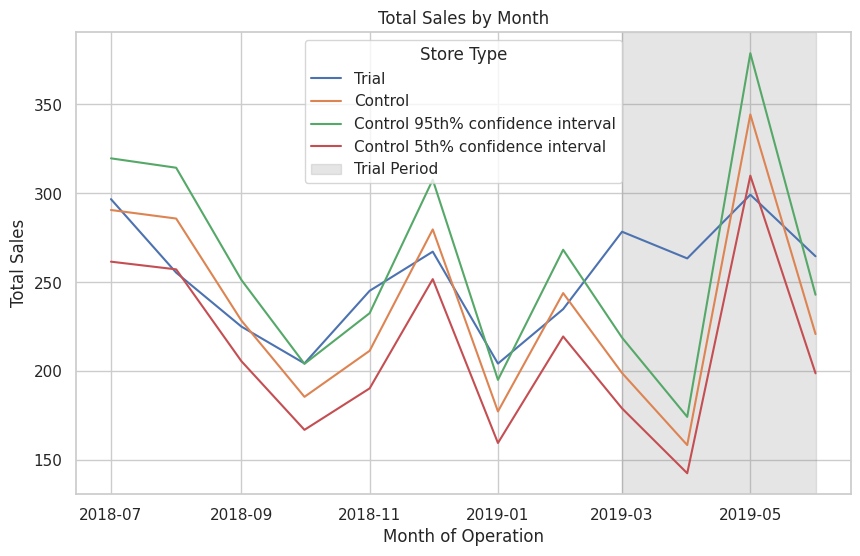

In [15]:
# Prepare data for visualization
past_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
past_sales['Store_type'] = past_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate 95th and 5th percentiles for control store
past_sales_95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_95['totSales'] = past_sales_95['totSales'] * (1 + std_dev_sales * 2)
past_sales_95['Store_type'] = 'Control 95th% confidence interval'

past_sales_5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_5['totSales'] = past_sales_5['totSales'] * (1 - std_dev_sales * 2)
past_sales_5['Store_type'] = 'Control 5th% confidence interval'

# Combine data for plotting
trial_assessment = pd.concat([past_sales, past_sales_95, past_sales_5])

# Create TransactionMonth column for plotting
trial_assessment['TransactionMonth'] = pd.to_datetime(trial_assessment['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='totSales', hue='Store_type')
plt.axvspan(pd.to_datetime('2019-03-01'), pd.to_datetime('2019-06-01'), color='gray', alpha=0.2, label='Trial Period')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(title='Store Type')
plt.show()

# Calculate and Apply Scaling Factor for Control Store Customers

This code performs the following steps:
1. **Calculate Scaling Factor**:
   - Computes a scaling factor to align the control store's total number of customers with the trial store's total number of customers during the pre-trial period (before February 2019).

2. **Apply Scaling Factor**:
   - Adjusts the control store's number of customers (`controlCustomers`) by multiplying it with the scaling factor to make it comparable to the trial store's customers.

In [16]:
# Calculate scaling factor for control store customers
scaling_factor_customers = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()
)

# Apply the scaling factor to control store customers
measure_over_time['controlCustomers'] = measure_over_time.apply(
    lambda row: row['nCustomers'] * scaling_factor_customers if row['STORE_NBR'] == control_store else row['nCustomers'],
    axis=1
)

# Calculate Percentage Difference Between Trial and Control Customers

This code performs the following steps:
1. **Filter Data for Trial and Control Customers**:
   - Extracts the number of customers (`nCustomers`) for the trial store and scaled control customers (`controlCustomers`) for the control store.

2. **Merge Trial and Control Customers**:
   - Combines the trial and control customer data on `YEARMONTH`.

3. **Calculate Percentage Difference**:
   - Computes the percentage difference between the trial store's customers and the scaled control store's customers.

In [17]:
# Filter data for trial and control customers
trial_customers = measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']]
control_customers = measure_over_time[measure_over_time['STORE_NBR'] == control_store][['YEARMONTH', 'controlCustomers']]

# Merge trial and control customers
percentage_diff_customers = pd.merge(control_customers, trial_customers, on='YEARMONTH')
percentage_diff_customers['percentageDiff'] = abs(percentage_diff_customers['controlCustomers'] - percentage_diff_customers['nCustomers']) / percentage_diff_customers['controlCustomers']

# Visualize Total Number of Customers Trends with Confidence Intervals

This code performs the following steps:
1. **Prepare Data for Visualization**:
   - Filters the data for the trial store and control store.
   - Assigns a `Store_type` column to classify stores as "Trial", "Control", or "Other stores".

2. **Calculate Confidence Intervals**:
   - Computes the 95th and 5th percentiles for the control store's number of customers using the standard deviation (`std_dev_sales`).

3. **Combine Data for Plotting**:
   - Concatenates the trial store, control store, and confidence interval data into a single DataFrame.

4. **Create TransactionMonth Column**:
   - Converts the `YEARMONTH` column into a proper datetime format for plotting.

5. **Plot Total Number of Customers Trends**:
   - Uses `seaborn.lineplot` to visualize the trends in the total number of customers for the trial store, control store, and confidence intervals.
   - Highlights the trial period (March 2019 to June 2019) with a shaded region.
   - Adds labels for the x-axis (Month of Operation), y-axis (Total Number of Customers), and a legend for store types.

<ipython-input-18-635acab8d69e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_customers['Store_type'] = past_customers['STORE_NBR'].apply(


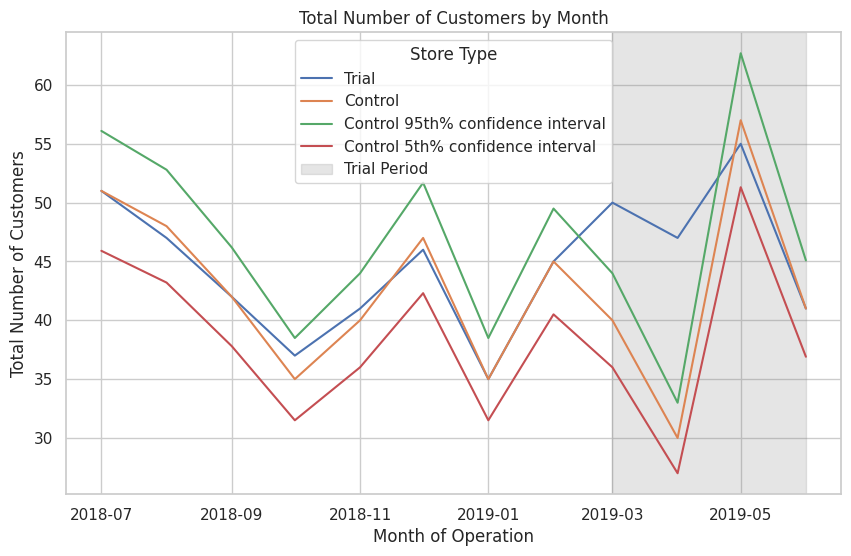

In [18]:
# Prepare data for visualization
past_customers = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
past_customers['Store_type'] = past_customers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate 95th and 5th percentiles for control store customers
past_customers_95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_95['nCustomers'] = past_customers_95['nCustomers'] * (1 + std_dev_sales * 2)
past_customers_95['Store_type'] = 'Control 95th% confidence interval'

past_customers_5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_5['nCustomers'] = past_customers_5['nCustomers'] * (1 - std_dev_sales * 2)
past_customers_5['Store_type'] = 'Control 5th% confidence interval'

# Combine data for plotting
trial_assessment_customers = pd.concat([past_customers, past_customers_95, past_customers_5])

# Create TransactionMonth column for plotting
trial_assessment_customers['TransactionMonth'] = pd.to_datetime(trial_assessment_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total customers
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment_customers, x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.axvspan(pd.to_datetime('2019-03-01'), pd.to_datetime('2019-06-01'), color='gray', alpha=0.2, label='Trial Period')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.legend(title='Store Type')
plt.show()

# Calculate Correlation and Magnitude Scores for Trial Store 86

This code performs the following steps:
1. Calculates the correlation scores for total sales (`totSales`) and number of customers (`nCustomers`) between the trial store (store 86) and all potential control stores.
2. Calculates the magnitude distance scores for total sales (`totSales`) and number of customers (`nCustomers`) between the trial store (store 86) and all potential control stores.

In [19]:
trial_store = 86

# Correlation scores
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

# Magnitude scores
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

In [20]:
# Combine correlation and magnitude scores
corr_weight = 0.5

# Total sales score
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = corr_weight * score_nSales['corr_measure'] + (1 - corr_weight) * score_nSales['mag_measure']

# Customer score
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['corr_measure'] + (1 - corr_weight) * score_nCustomers['mag_measure']

# Combine scores across drivers
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control['finalControlScore'] = 0.5 * score_control['scoreNSales'] + 0.5 * score_control['scoreNCust']

# Select the control store
control_store = score_control[score_control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False).iloc[1]['Store2']
print(f"Control store for trial store {trial_store}: {control_store}")

Control store for trial store 86: 155.0


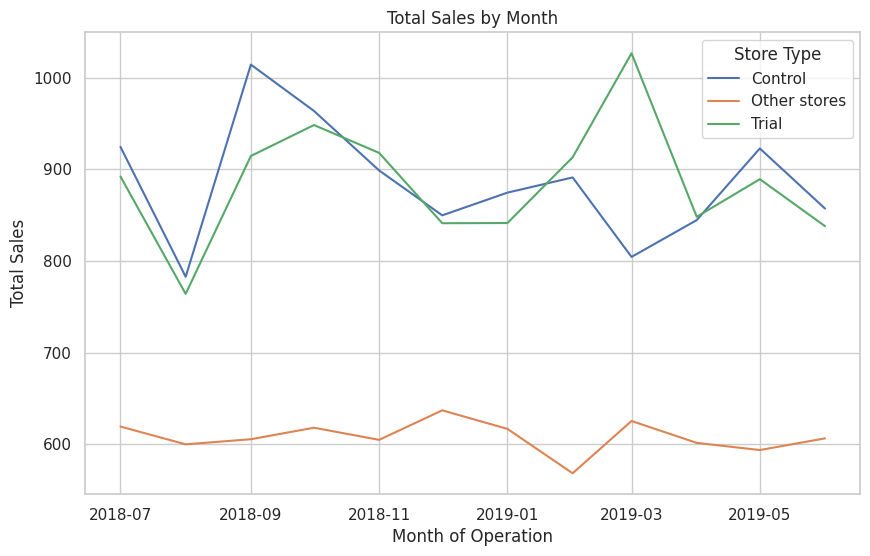

In [21]:
# Visual check for total sales
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    totSales=('totSales', 'mean')
).reset_index()

past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(title='Store Type')
plt.show()

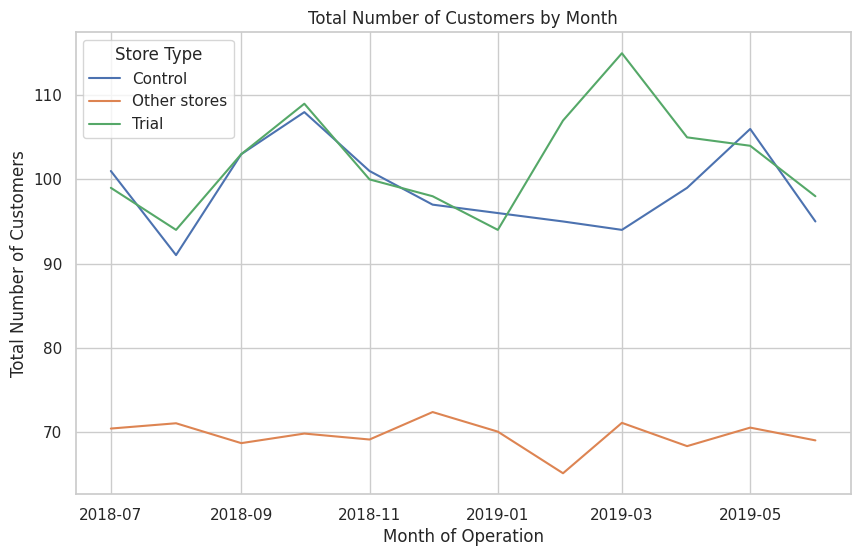

In [22]:
# Visual check for total number of customers
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Group by YEARMONTH and Store_type to calculate the average number of customers
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    numberCustomers=('nCustomers', 'mean')
).reset_index()

# Create TransactionMonth column for plotting
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total number of customers trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='numberCustomers', hue='Store_type')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.legend(title='Store Type')
plt.show()

In [23]:
# Calculate scaling factor for control store sales
scaling_factor_sales = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()
)

# Apply the scaling factor to control store sales
measure_over_time['controlSales'] = measure_over_time.apply(
    lambda row: row['totSales'] * scaling_factor_sales if row['STORE_NBR'] == control_store else row['totSales'],
    axis=1
)

In [24]:
# Filter data for trial and control stores
trial_sales = measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']]
control_sales = measure_over_time[measure_over_time['STORE_NBR'] == control_store][['YEARMONTH', 'controlSales']]

# Merge trial and control sales
percentage_diff_sales = pd.merge(control_sales, trial_sales, on='YEARMONTH')
percentage_diff_sales['percentageDiff'] = abs(percentage_diff_sales['controlSales'] - percentage_diff_sales['totSales']) / percentage_diff_sales['controlSales']

In [25]:
# Calculate standard deviation of percentage difference in the pre-trial period
std_dev_sales = percentage_diff_sales[percentage_diff_sales['YEARMONTH'] < 201902]['percentageDiff'].std()

# Degrees of freedom
degrees_of_freedom = 7  # 8 months in pre-trial period, so 8 - 1 = 7

# Calculate t-values for the trial period
percentage_diff_sales['tValue'] = percentage_diff_sales['percentageDiff'] / std_dev_sales
percentage_diff_sales['TransactionMonth'] = pd.to_datetime(percentage_diff_sales['YEARMONTH'].astype(str), format='%Y%m')

# Find the 95th percentile of the t-distribution
from scipy.stats import t
t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile of t-distribution: {t_critical}")

95th percentile of t-distribution: 1.894578605061305


<ipython-input-26-42ae3ca038e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_sales['Store_type'] = past_sales['STORE_NBR'].apply(


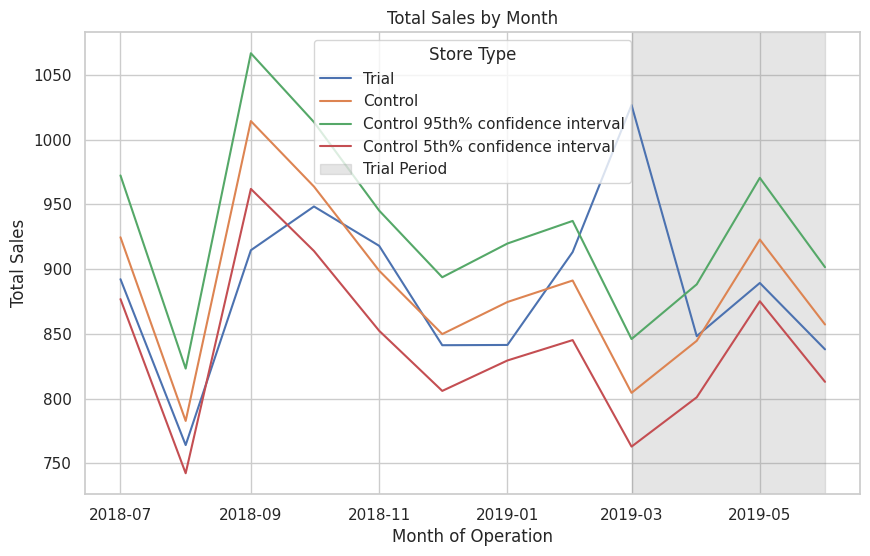

In [26]:
# Prepare data for visualization
past_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
past_sales['Store_type'] = past_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate 95th and 5th percentiles for control store
past_sales_95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_95['totSales'] = past_sales_95['totSales'] * (1 + std_dev_sales * 2)
past_sales_95['Store_type'] = 'Control 95th% confidence interval'

past_sales_5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_5['totSales'] = past_sales_5['totSales'] * (1 - std_dev_sales * 2)
past_sales_5['Store_type'] = 'Control 5th% confidence interval'

# Combine data for plotting
trial_assessment = pd.concat([past_sales, past_sales_95, past_sales_5])

# Create TransactionMonth column for plotting
trial_assessment['TransactionMonth'] = pd.to_datetime(trial_assessment['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='totSales', hue='Store_type')
plt.axvspan(pd.to_datetime('2019-03-01'), pd.to_datetime('2019-06-01'), color='gray', alpha=0.2, label='Trial Period')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(title='Store Type')
plt.show()

In [27]:
# Calculate scaling factor for control store customers
scaling_factor_customers = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()
)

# Apply the scaling factor to control store customers
measure_over_time['controlCustomers'] = measure_over_time.apply(
    lambda row: row['nCustomers'] * scaling_factor_customers if row['STORE_NBR'] == control_store else row['nCustomers'],
    axis=1
)

In [28]:
# Filter data for trial and control customers
trial_customers = measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']]
control_customers = measure_over_time[measure_over_time['STORE_NBR'] == control_store][['YEARMONTH', 'controlCustomers']]

# Merge trial and control customers
percentage_diff_customers = pd.merge(control_customers, trial_customers, on='YEARMONTH')
percentage_diff_customers['percentageDiff'] = abs(percentage_diff_customers['controlCustomers'] - percentage_diff_customers['nCustomers']) / percentage_diff_customers['controlCustomers']

<ipython-input-29-635acab8d69e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_customers['Store_type'] = past_customers['STORE_NBR'].apply(


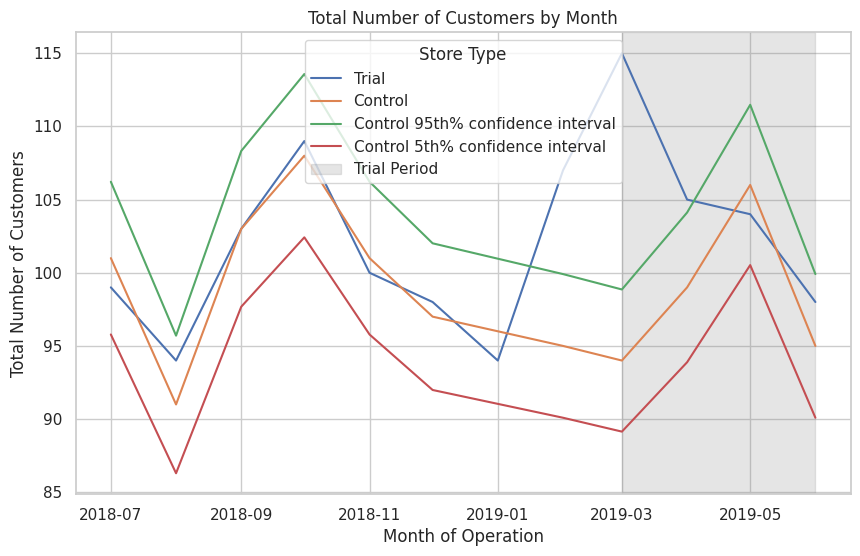

In [29]:
# Prepare data for visualization
past_customers = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
past_customers['Store_type'] = past_customers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate 95th and 5th percentiles for control store customers
past_customers_95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_95['nCustomers'] = past_customers_95['nCustomers'] * (1 + std_dev_sales * 2)
past_customers_95['Store_type'] = 'Control 95th% confidence interval'

past_customers_5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_5['nCustomers'] = past_customers_5['nCustomers'] * (1 - std_dev_sales * 2)
past_customers_5['Store_type'] = 'Control 5th% confidence interval'

# Combine data for plotting
trial_assessment_customers = pd.concat([past_customers, past_customers_95, past_customers_5])

# Create TransactionMonth column for plotting
trial_assessment_customers['TransactionMonth'] = pd.to_datetime(trial_assessment_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total customers
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment_customers, x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.axvspan(pd.to_datetime('2019-03-01'), pd.to_datetime('2019-06-01'), color='gray', alpha=0.2, label='Trial Period')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.legend(title='Store Type')
plt.show()

# Calculate Correlation and Magnitude Scores for Trial Store 88

This code performs the following steps:
1. Calculates the correlation scores for total sales (`totSales`) and number of customers (`nCustomers`) between the trial store (store 88) and all potential control stores.
2. Calculates the magnitude distance scores for total sales (`totSales`) and number of customers (`nCustomers`) between the trial store (store 88) and all potential control stores.

In [30]:
trial_store = 88

# Correlation scores
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

# Magnitude scores
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

In [31]:
# Combine correlation and magnitude scores
corr_weight = 0.5

# Total sales score
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = corr_weight * score_nSales['corr_measure'] + (1 - corr_weight) * score_nSales['mag_measure']

# Customer score
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['corr_measure'] + (1 - corr_weight) * score_nCustomers['mag_measure']

# Combine scores across drivers
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control['finalControlScore'] = 0.5 * score_control['scoreNSales'] + 0.5 * score_control['scoreNCust']

# Select the control store
control_store = score_control[score_control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False).iloc[1]['Store2']
print(f"Control store for trial store {trial_store}: {control_store}")

Control store for trial store 88: 237.0


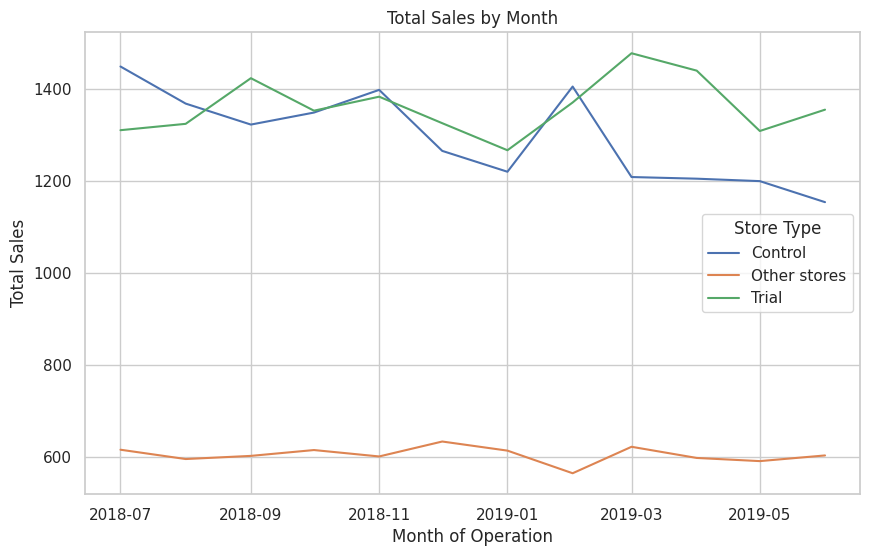

In [32]:
# Visual check for total sales
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    totSales=('totSales', 'mean')
).reset_index()

past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(title='Store Type')
plt.show()

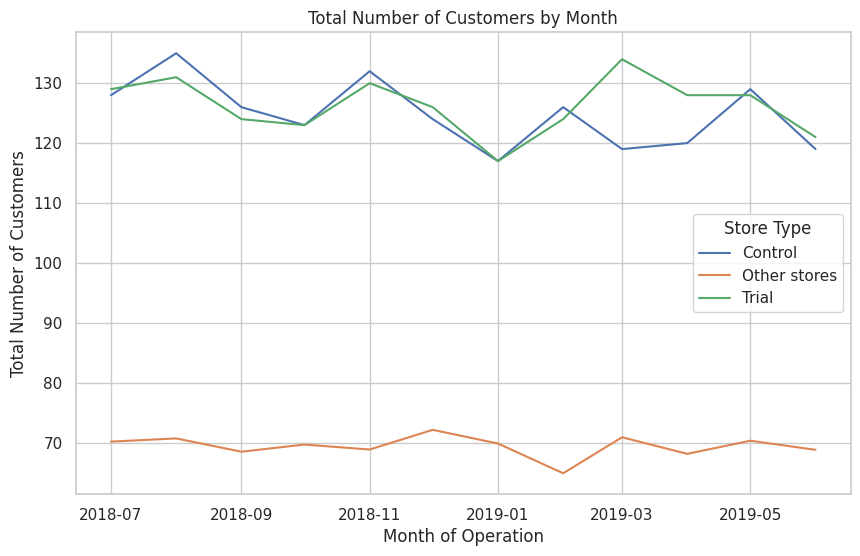

In [33]:
# Visual check for total number of customers
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Group by YEARMONTH and Store_type to calculate the average number of customers
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    numberCustomers=('nCustomers', 'mean')
).reset_index()

# Create TransactionMonth column for plotting
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total number of customers trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='numberCustomers', hue='Store_type')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.legend(title='Store Type')
plt.show()

In [34]:
# Calculate scaling factor for control store sales
scaling_factor_sales = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()
)

# Apply the scaling factor to control store sales
measure_over_time['controlSales'] = measure_over_time.apply(
    lambda row: row['totSales'] * scaling_factor_sales if row['STORE_NBR'] == control_store else row['totSales'],
    axis=1
)

In [35]:
# Filter data for trial and control stores
trial_sales = measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']]
control_sales = measure_over_time[measure_over_time['STORE_NBR'] == control_store][['YEARMONTH', 'controlSales']]

# Merge trial and control sales
percentage_diff_sales = pd.merge(control_sales, trial_sales, on='YEARMONTH')
percentage_diff_sales['percentageDiff'] = abs(percentage_diff_sales['controlSales'] - percentage_diff_sales['totSales']) / percentage_diff_sales['controlSales']

In [36]:
# Calculate standard deviation of percentage difference in the pre-trial period
std_dev_sales = percentage_diff_sales[percentage_diff_sales['YEARMONTH'] < 201902]['percentageDiff'].std()

# Degrees of freedom
degrees_of_freedom = 7  # 8 months in pre-trial period, so 8 - 1 = 7

# Calculate t-values for the trial period
percentage_diff_sales['tValue'] = percentage_diff_sales['percentageDiff'] / std_dev_sales
percentage_diff_sales['TransactionMonth'] = pd.to_datetime(percentage_diff_sales['YEARMONTH'].astype(str), format='%Y%m')

# Find the 95th percentile of the t-distribution
from scipy.stats import t
t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile of t-distribution: {t_critical}")

95th percentile of t-distribution: 1.894578605061305


<ipython-input-37-42ae3ca038e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_sales['Store_type'] = past_sales['STORE_NBR'].apply(


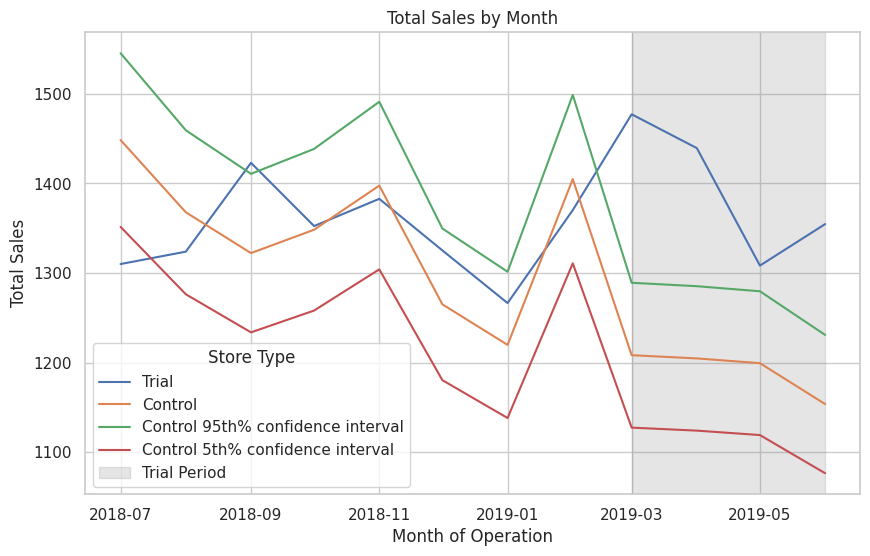

In [37]:
# Prepare data for visualization
past_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
past_sales['Store_type'] = past_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate 95th and 5th percentiles for control store
past_sales_95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_95['totSales'] = past_sales_95['totSales'] * (1 + std_dev_sales * 2)
past_sales_95['Store_type'] = 'Control 95th% confidence interval'

past_sales_5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_5['totSales'] = past_sales_5['totSales'] * (1 - std_dev_sales * 2)
past_sales_5['Store_type'] = 'Control 5th% confidence interval'

# Combine data for plotting
trial_assessment = pd.concat([past_sales, past_sales_95, past_sales_5])

# Create TransactionMonth column for plotting
trial_assessment['TransactionMonth'] = pd.to_datetime(trial_assessment['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='totSales', hue='Store_type')
plt.axvspan(pd.to_datetime('2019-03-01'), pd.to_datetime('2019-06-01'), color='gray', alpha=0.2, label='Trial Period')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(title='Store Type')
plt.show()

In [38]:
# Calculate scaling factor for control store customers
scaling_factor_customers = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()
)

# Apply the scaling factor to control store customers
measure_over_time['controlCustomers'] = measure_over_time.apply(
    lambda row: row['nCustomers'] * scaling_factor_customers if row['STORE_NBR'] == control_store else row['nCustomers'],
    axis=1
)

In [39]:
# Filter data for trial and control customers
trial_customers = measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']]
control_customers = measure_over_time[measure_over_time['STORE_NBR'] == control_store][['YEARMONTH', 'controlCustomers']]

# Merge trial and control customers
percentage_diff_customers = pd.merge(control_customers, trial_customers, on='YEARMONTH')
percentage_diff_customers['percentageDiff'] = abs(percentage_diff_customers['controlCustomers'] - percentage_diff_customers['nCustomers']) / percentage_diff_customers['controlCustomers']

<ipython-input-40-635acab8d69e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_customers['Store_type'] = past_customers['STORE_NBR'].apply(


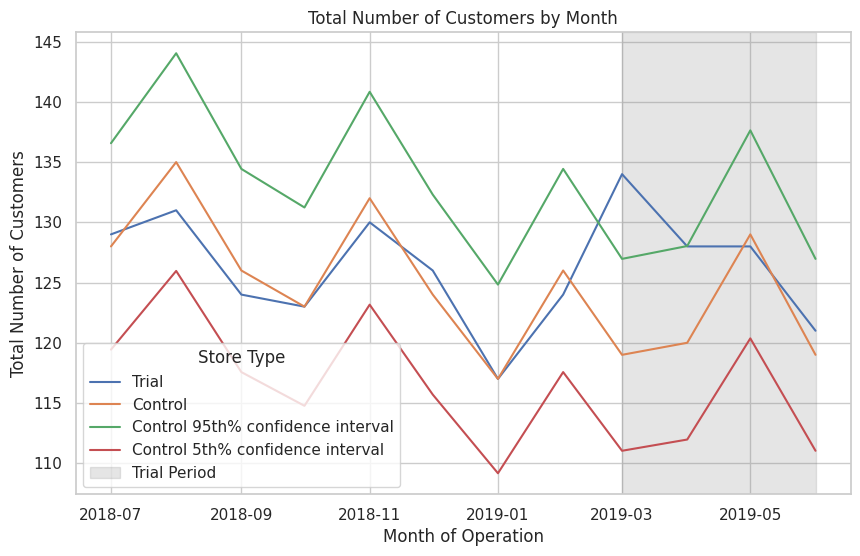

In [40]:
# Prepare data for visualization
past_customers = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
past_customers['Store_type'] = past_customers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate 95th and 5th percentiles for control store customers
past_customers_95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_95['nCustomers'] = past_customers_95['nCustomers'] * (1 + std_dev_sales * 2)
past_customers_95['Store_type'] = 'Control 95th% confidence interval'

past_customers_5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_5['nCustomers'] = past_customers_5['nCustomers'] * (1 - std_dev_sales * 2)
past_customers_5['Store_type'] = 'Control 5th% confidence interval'

# Combine data for plotting
trial_assessment_customers = pd.concat([past_customers, past_customers_95, past_customers_5])

# Create TransactionMonth column for plotting
trial_assessment_customers['TransactionMonth'] = pd.to_datetime(trial_assessment_customers['YEARMONTH'].astype(str), format='%Y%m')

# Plot total customers
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment_customers, x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.axvspan(pd.to_datetime('2019-03-01'), pd.to_datetime('2019-06-01'), color='gray', alpha=0.2, label='Trial Period')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.legend(title='Store Type')
plt.show()

Conclusion
Based on our analysis, we have identified control stores 233, 155, and 237 corresponding to trial stores 77, 86, and 88, respectively. The results for trial stores 77 and 88 during the trial period indicate a significant improvement in at least two of the three trial months. In contrast, trial store 86 did not show the same level of improvement. We may need to check with the client to confirm whether there were any differences in the implementation of the trial at store 86.

Overall, the trial period demonstrates a significant increase in sales across the trial stores, with key metrics such as total sales, units sold, repeat customer count, and average transactions per customer showing positive results. Trial store 88, in particular, had slightly higher average transactions compared to its control store, while stores 77 and 86 are catching up to their respective control stores.

The data suggests that the new store layout is having a positive impact on performance. Based on these findings, my recommendation is to expand the number of trial stores and conduct a follow-up analysis in three months to assess whether the sales uplift is sustained and continues to stabilize at an improved level.